![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 4 - Deep Learning Basics</center>
### <center> Data Pre-processing and Weights Initialization</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/04_OptimizationMethods/MainInitialization1.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

np.random.seed(1)

###  What we have so far:
This part will grow so we will move this to its own module

In [3]:
class ReLULayer:
    def __init__(self):
        self.dGrads = {}

    def Forward(self, mX):
        self.mX = mX                 #-- store for Backward
        mZ      = np.maximum(mX, 0)

        return mZ

    def Backward(self, mDz):
        mX    = self.mX
        mMask = (mX > 0).astype(float)

        mDx   = mDz * mMask

        return mDx

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def CrossEntropyLoss(vY, mZ):
    '''
    Returns both the loss and the gradient w.r.t the input (mZ)
    '''
    mHatY  = np.exp(mZ)
    mHatY /= np.sum(mHatY, axis=0)
    N      = len(vY)
    loss   = -np.log(mHatY[vY,range(N)]).mean()

    mDz               = mHatY
    mDz[vY,range(N)] -= 1
    mDz              /= N

    return loss, mDz

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
class Model:
    def __init__(self, lLayers):
        self.lLayers = lLayers

    def Forward(self, mX):
        for oLayer in self.lLayers:
            mX = oLayer.Forward(mX)
        return mX

    def Backward(self, mDz):
        for oLayer in reversed(self.lLayers):
            mDz = oLayer.Backward(mDz)

### Adding Kaiming initialization to the linear layer:

In [4]:
class LinearLayer:
    def __init__(self, dIn, dOut, init='Kaiming'):
        if init == 'Kaiming':
            mW = np.random.randn(dOut, dIn) * np.sqrt(2 / dIn)
        elif init == 'Xavier':
            mW = np.random.randn(dOut, dIn) * np.sqrt(1 / dIn)
        else:
            mW = np.random.randn(dOut, dIn) / dIn #-- this is how we initialize previously
        vB = np.zeros(dOut)

        self.dParams = {'mW' : mW, 'vB': vB}
        self.dGrads  = {}

    def Forward(self, mX):
        mW      = self.dParams['mW']
        vB      = self.dParams['vB']
        self.mX = mX                   #-- store for Backward
        mZ      = mW @ mX + vB[:,None]

        return mZ

    def Backward(self, mDz):
        mW  = self.dParams['mW']

        vDb = mDz.sum(axis=1)
        mDw = mDz @ self.mX.T
        mDx = mW.T @ mDz

        self.dGrads['vB'] = vDb
        self.dGrads['mW'] = mDw

        return mDx


### Get Fashion MNIST dataset

In [5]:
import torchvision
import torchvision.transforms as transforms

#-- For now, we use PyTorch just to get the data:
oTorchTrainSet = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True, transform=transforms.ToTensor())
# oTorchTestSet  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

lClasses = oTorchTrainSet.classes
mX       = oTorchTrainSet.data.view(-1,784).numpy() / 255
vY       = oTorchTrainSet.targets.numpy()
mX.shape, vY.shape, lClasses

((60000, 784),
 (60000,),
 ['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'])

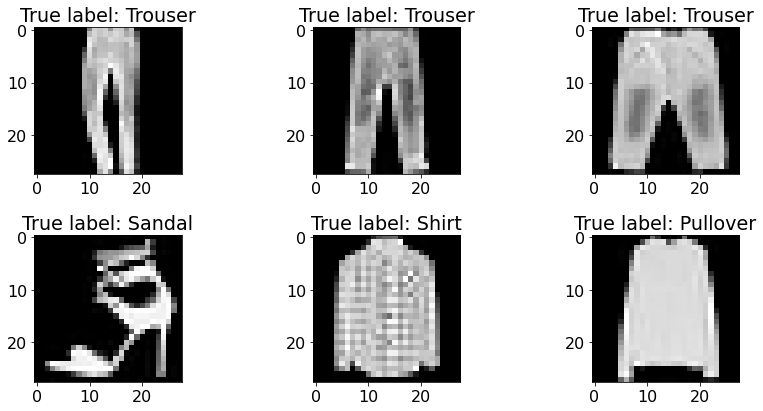

In [6]:
#-- Plot a few examples:
N, d   = mX.shape
fig, _ = plt.subplots(2, 3, figsize=(12,6))
for ax in fig.axes:
    idx = np.random.randint(0, N)
    ax.imshow(np.reshape(mX[idx,:], (28, 28)), cmap='gray')
    ax.set_title('True label: ' + str(lClasses[vY[idx]]))
    
plt.tight_layout()
plt.show()

###  Split to train and validation:

In [7]:
from sklearn.model_selection import train_test_split

Ntrain = 55000
Nval   = 5000
mTrainX, mValX, vTrainY, vValY = train_test_split(mX, vY, train_size=Ntrain, test_size=Nval)

(mTrainX.shape, 
vTrainY.shape, 
mValX.shape,  
vValY.shape)

((55000, 784), (55000,), (5000, 784), (5000,))

### Define the training loop:

In [8]:
import time

#-- Classification accuracy:
def Accuracy(mHatY, vY):
    vHatY    = np.argmax(mHatY, axis=0)
    accuracy = (vHatY == vY).astype(float).mean()
    return accuracy
    
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def TrainLoop(oModel, mX, vY, learningRate):
    #-- Forward:
    mZ        = oModel.Forward(mX)
    loss, mDz = CrossEntropyLoss(vY, mZ)

    #-- Backward:
    oModel.Backward(mDz)

    #-- Update parameters (vanilla gradient descnet)
    for oLayer in oModel.lLayers:
        for sParam in oLayer.dGrads:
            oLayer.dParams[sParam] -= learningRate * oLayer.dGrads[sParam]
              
    #-- Check accuracy:
    acc = Accuracy(mZ, vY)
            
    return loss, acc

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def ValidationLoop(oModel, mX, vY):
    #-- Forward:
    mZ      = oModel.Forward(mX)
    loss, _ = CrossEntropyLoss(vY, mZ)
    acc     = Accuracy(mZ, vY)
    
    return loss, acc

In [9]:
def TrainModel(oModel, mTrainX, vTrainY, mValX, vValY, numEpochs, learningRate):
    lTrainLoss = []
    lValLoss   = []
    lTrainAcc  = []
    lValAcc    = []
    for epoch in range(numEpochs):
        startTime           = time.time()
        #-- Train:
        trainLoss, trainAcc = TrainLoop(oModel, mTrainX, vTrainY, learningRate)
        #-- Validation:
        valLoss,   valAcc   = ValidationLoop(oModel, mValX, vValY)
        endTime             = time.time()

        #-- Display:
        print('Epoch '              f'{epoch:3d}:',     end='')
        print(' | Train loss: '     f'{trainLoss:.5f}', end='')
        print(' | Val loss: '       f'{valLoss:.5f}',   end='')
        print(' | Train Accuracy: ' f'{trainAcc:2.4f}', end='')
        print(' | Val Accuracy: '   f'{valAcc:2.4f}',   end='')
        print(' | epoch time: '     f'{(endTime-startTime):3.3f} |')
        
        lTrainLoss.append(trainLoss)
        lValLoss.append(valLoss)
        lTrainAcc.append(trainAcc)
        lValAcc.append(valAcc)
    
    return lTrainLoss, lValLoss, lTrainAcc, lValAcc


### Train *without* normalizing and initialization:

In [10]:
oModel = Model([
        LinearLayer(784, 200, []),
        ReLULayer(),
        LinearLayer(200, 10, []),
])

_, lValLossV1, _, lValAccV1 = TrainModel(oModel, mTrainX.T, vTrainY, mValX.T, vValY, 30, 2e-1)

Epoch   0: | Train loss: 2.30268 | Val loss: 2.30133 | Train Accuracy: 0.1134 | Val Accuracy: 0.2036 | epoch time: 0.857 |
Epoch   1: | Train loss: 2.30131 | Val loss: 2.29998 | Train Accuracy: 0.2073 | Val Accuracy: 0.2800 | epoch time: 0.831 |
Epoch   2: | Train loss: 2.29995 | Val loss: 2.29832 | Train Accuracy: 0.2801 | Val Accuracy: 0.3558 | epoch time: 0.875 |
Epoch   3: | Train loss: 2.29828 | Val loss: 2.29621 | Train Accuracy: 0.3593 | Val Accuracy: 0.3756 | epoch time: 0.840 |
Epoch   4: | Train loss: 2.29616 | Val loss: 2.29341 | Train Accuracy: 0.3848 | Val Accuracy: 0.3976 | epoch time: 0.827 |
Epoch   5: | Train loss: 2.29333 | Val loss: 2.28962 | Train Accuracy: 0.4091 | Val Accuracy: 0.3930 | epoch time: 0.841 |
Epoch   6: | Train loss: 2.28952 | Val loss: 2.28447 | Train Accuracy: 0.4045 | Val Accuracy: 0.3962 | epoch time: 0.833 |
Epoch   7: | Train loss: 2.28432 | Val loss: 2.27743 | Train Accuracy: 0.4017 | Val Accuracy: 0.3808 | epoch time: 0.937 |
Epoch   8: | Tra

###  Normalize data:

In [11]:
vMean = np.mean(mX, axis=0)
vStd  = np.std(mX, axis=0)
mX    = (mX - vMean) / vStd

### Train *with* normalizing and initialization:

In [12]:
oModel = Model([
        LinearLayer(784, 200, init='Kaiming'),
        ReLULayer(),
        LinearLayer(200, 10,  init='Kaiming'),
])

_, lValLossV2, _, lValAccV2 = TrainModel(oModel, mTrainX.T, vTrainY, mValX.T, vValY, 30, 5e-2)

Epoch   0: | Train loss: 2.28628 | Val loss: 2.10706 | Train Accuracy: 0.1667 | Val Accuracy: 0.2042 | epoch time: 0.852 |
Epoch   1: | Train loss: 2.10462 | Val loss: 1.98652 | Train Accuracy: 0.2105 | Val Accuracy: 0.3130 | epoch time: 0.885 |
Epoch   2: | Train loss: 1.98424 | Val loss: 1.88864 | Train Accuracy: 0.3135 | Val Accuracy: 0.4434 | epoch time: 0.897 |
Epoch   3: | Train loss: 1.88624 | Val loss: 1.80374 | Train Accuracy: 0.4411 | Val Accuracy: 0.5098 | epoch time: 0.916 |
Epoch   4: | Train loss: 1.80116 | Val loss: 1.72849 | Train Accuracy: 0.5072 | Val Accuracy: 0.5442 | epoch time: 0.824 |
Epoch   5: | Train loss: 1.72561 | Val loss: 1.66108 | Train Accuracy: 0.5415 | Val Accuracy: 0.5632 | epoch time: 0.914 |
Epoch   6: | Train loss: 1.65802 | Val loss: 1.60041 | Train Accuracy: 0.5651 | Val Accuracy: 0.5792 | epoch time: 0.965 |
Epoch   7: | Train loss: 1.59721 | Val loss: 1.54560 | Train Accuracy: 0.5829 | Val Accuracy: 0.5936 | epoch time: 0.912 |
Epoch   8: | Tra

### Compare the two configurations:

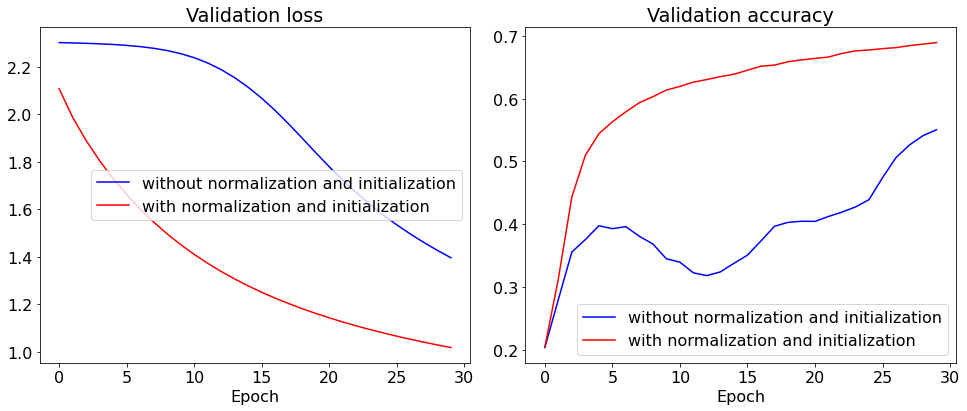

In [15]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(lValLossV1, 'b', label='without normalization and initialization')
plt.plot(lValLossV2, 'r', label='with normalization and initialization')
plt.legend()
plt.xlabel('Epoch')
plt.title('Validation loss')

plt.subplot(1,2,2)
plt.plot(lValAccV1, 'b', label='without normalization and initialization')
plt.plot(lValAccV2, 'r', label='with normalization and initialization')
plt.legend()
plt.xlabel('Epoch')
plt.title('Validation accuracy')

plt.tight_layout()
plt.show()